In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
import random
from torchvision.utils import save_image
%matplotlib inline

In [2]:
class VAE(torch.nn.Module):
    def __init__(self, input_shape):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 2)
        self.fc32 = nn.Linear(256, 2)
        self.fc4 = nn.Linear(2, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, input_shape)
        
    def encoder(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(h1))
        return self.fc31(h1), self.fc32(h1)
    
    def reparameterize(self, mu, logvar):
        #adding stochastic part to variable z by eps
        std = torch.exp(0.5 * logvar)
        eps = torch.randn((std.shape[0], std.shape[1]))
        z = mu + std*eps
        return z
    
    def decoder(self, z):
        h2 = F.relu(self.fc4(z))
        h2 = F.relu(self.fc5(h2))
        return torch.sigmoid(self.fc6(h2))
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform)

train_set, test_set = random_split(train_dataset, (48000, 12000))

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=False)

In [4]:
vae_model = VAE(input_shape = 784)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr = 0.001)

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    #if reduction was left default the loss would stay the same 
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    #use KL-divergence to force 'z' mean=0 and std=1
    kl_div = -0.5* torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl_div

In [6]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs):
    loss_list = []
    acc_list = []
    for epoch in range(epochs):
        loss = 0.0
        valid_loss = 0.0
        for inputs, _ in train_loader:
            #reshape input images
            inputs = inputs.view(-1, 784)
            #reser gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs, mu, logvar = model(inputs)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, inputs, mu, logvar)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
        #compute the epoch training loss
        loss = loss/len(train_loader.dataset)
        loss_list.append(loss)
        
        model.eval()
        for inputs, _ in val_loader:
            #reshape input images
            inputs = inputs.view(-1, 784)
            #compute reconstruction
            outputs, mu, logvar = model(inputs)
            #compute validation loss
            valid_loss += loss_fn(outputs, inputs, mu, logvar)
        valid_loss /= len(val_loader.dataset)
        
        acc_list.append(valid_loss)
        #print info
        if epoch % 10 == 9 or epoch == 0:
            print('Epoch {} of {}, training loss = {:.3f}, validation loss = {:.3f}'.format(epoch+1, epochs, loss, valid_loss))
    return loss_list, acc_list

In [7]:
vae_loss_list, val_list = train(vae_model, train_loader, test_loader, vae_optimizer, vae_loss,100)

Epoch 1 of 100, training loss = 188.081, validation loss = 167.992
Epoch 10 of 100, training loss = 144.969, validation loss = 146.498
Epoch 20 of 100, training loss = 140.448, validation loss = 142.887
Epoch 30 of 100, training loss = 138.643, validation loss = 140.975
Epoch 40 of 100, training loss = 137.202, validation loss = 140.371
Epoch 50 of 100, training loss = 136.126, validation loss = 139.883
Epoch 60 of 100, training loss = 135.077, validation loss = 139.819
Epoch 70 of 100, training loss = 134.902, validation loss = 139.058
Epoch 80 of 100, training loss = 133.575, validation loss = 138.626
Epoch 90 of 100, training loss = 133.570, validation loss = 138.525
Epoch 100 of 100, training loss = 132.759, validation loss = 139.031


In [9]:
def draw_samples(data_set, model):
    fig, ax = plt.subplots(2,9, figsize=(20,5))
    for i in range(9):
        num = random.randint(0,len(data_set))
        out, _, _ = model(data_set[num][0].view(-1, 784))
        out = out/out.max().item()
        out = out.view(28,28)
        ax[0][i].imshow(data_set[num][0].reshape((28,28)), cmap='Greys_r')
        ax[0][i].set_axis_off()
        ax[1][i].imshow(out.detach(), cmap='Greys_r')
        ax[1][i].set_axis_off()
        if i%9 == 4:
            ax[0][i].set_title('Original', size=20)
            ax[1][i].set_title('Reconstructed', size=20)
        plt.subplots_adjust(wspace = 0, hspace = 0.2)

    plt.show()
    fig.savefig('VAE_sample.png', dpi=300)

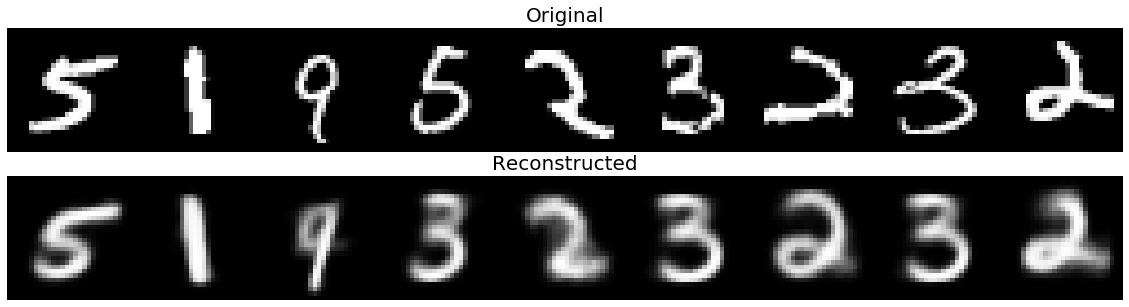

In [10]:
draw_samples(test_set, vae_model)

In [11]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = torch.distributions.Normal(0, 1)
    grid_x = torch.tensor(np.linspace(-2, 2, n))
    grid_y = torch.tensor(np.linspace(-2, 2, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor(np.array([[xi, yi]]), dtype=torch.float32)
            x_decoded = model.decoder(z)
            digit = x_decoded.reshape((-1,digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.detach().numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()
    plt.savefig('generated_imgs.png', dpi=200)

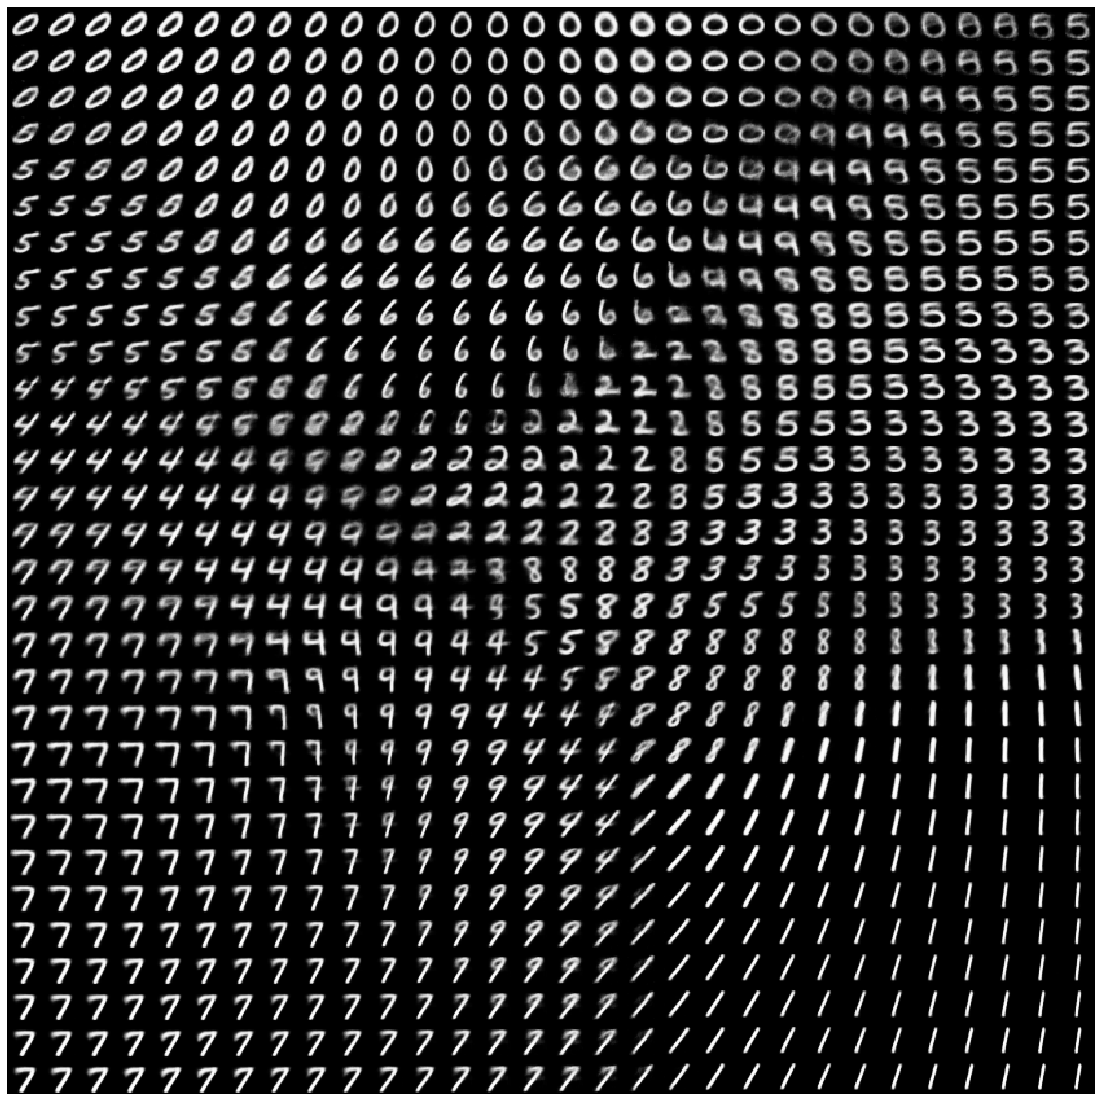

<Figure size 432x288 with 0 Axes>

In [12]:
plot_latent_images(vae_model, 30)

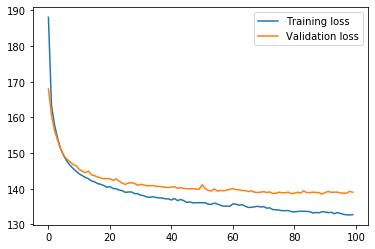

In [13]:
plt.plot(range(len(vae_loss_list)), vae_loss_list, label='Training loss')
plt.plot(range(len(val_list)), val_list, label='Validation loss')
plt.legend()
plt.show()